**ReadME**  
**This Version Does not contain any test Cases, Please refer to V1 or V2 for detailed Test Case Output**  
* V1: 25 Historical Quarters Data (5 Assets)
* V2: 100 Historial Quarters Data (5 Assets)

**Overview of the Entire JupyterNotebook**  
Section 1: Required Libraries  
Section 2: Data Processing
* 2.1 Single Asset Data Processing  
* 2.2 Single Asset Test Case  
* 2.3 Multi Asset Data Processing  
* 2.4 Multi Asset Test Case

Section 3: LSTM Machine Learning Estimator  
* 3.1 Pre-Processing
* 3.2 Pre-Processing Test Case
* 3.3 LSTM Model SetUp
* 3.4 LSTM Test Case

Section 4: ChatGPT 15 Asset Main Case

**Use Intruction**  
Please run all the sections with functions to construct the framework, Test Case Sections are optional to run

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Section 1: Required Libraries**

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Dense
from tensorflow.keras.regularizers import l2

**Section 2: Data Processing**  
Section 2.1 Single Asset Data Processing

In [3]:
def get_historical_returns(ticker, start_date, end_date, frequency="monthly"):
    'Function to fetch Historical Price data and compute returns'

    data = yf.download(ticker,start=start_date, end=end_date)

    # Calculate Daily Returns
    daily_data = data.copy()
    daily_data['Return'] = daily_data['Close'].pct_change()
    daily_returns = daily_data[['Return']].dropna()

    # Calculate Monthly Returns
    monthly_data = data.copy()
    monthly_data['Return'] = monthly_data['Close']
    monthly_data = monthly_data['Return'].resample('M').last()
    monthly_returns = monthly_data.pct_change()
    monthly_returns = monthly_returns.dropna()

    if frequency == "daily": return daily_returns
    if frequency == "monthly": return monthly_returns

    return monthly_data

def resample_quaterly_data(quaterly_data, target_data):
    'Repeat the quaterly available ratios to same frequency as target return'

    quaterly_data.index = pd.to_datetime(quaterly_data.index)
    target_data.index = pd.to_datetime(target_data.index)

    # Resample the quaterly data to daily frequency using Forward Fill
    quaterly_data.index = quaterly_data.index + pd.DateOffset(days=1)
    aligned_quaterly_data = quaterly_data.reindex(target_data.index, method='ffill')

    aligned_quaterly_data = aligned_quaterly_data.dropna()
    return aligned_quaterly_data


def load_features(path_to_file, ticker, start_date, end_date):
    'Function to Load all features for a single company'

    # Load the Excel file and read Data from the file
    file_path = path_to_file + ticker + '.xlsx'
    sheet_name = ticker + '-US'
    data = pd.read_excel(file_path, sheet_name=sheet_name, engine='openpyxl')

    # Remove rows with any NaN values
    # Because time frame is longer, cannot apply this
    # data = data.dropna()

    # Reset the index of the DataFrame and drop the old index
    data = data.reset_index(drop=True)

    data = data.set_index('Date').T
    data.index = pd.to_datetime(data.index, format='%b \'%y')
    data.index = data.index + pd.offsets.MonthEnd()
    ratio_data = data.apply(pd.to_numeric)

    # Select a few columns
    pe_column = 'Price/Earnings'
    pb_column = 'Price/Book Value'
    roa_column = 'Return on Assets'
    roe_column = 'Return on Equity '
    fcf_column = 'Free Cash Flow per Share'
    ratio_data = data[[pe_column, pb_column, roa_column, roe_column, fcf_column]]

    # Drop N/A dates
    # Removing rows with any NaN values
    ratio_data = ratio_data.dropna()

    # Process Return Data
    returns_data = get_historical_returns(ticker, start_date, end_date)
    adjusted_ratio_data = resample_quaterly_data(ratio_data, returns_data)
    features = pd.concat([adjusted_ratio_data, returns_data],axis=1)

    return features

Section 2.3 Multi Asset Data Processing

In [4]:
def multi_df(path_to_file, ticker_list, start_date, end_date):
    company_data = {}
    for ticker in ticker_list:
        company_data[ticker] = load_features(path_to_file, ticker, start_date, end_date)

    # Initialize a list to hold DataFrames with the new multi-index
    multi_index_dfs = []

    for company, df in company_data.items():
        # Set the company name as an additional level in the index
        df_multi_index = df.copy()
        df_multi_index['Company'] = company
        df_multi_index.set_index(['Company', df_multi_index.index], inplace=True)

        # Append to the list
        multi_index_dfs.append(df_multi_index)

    # Concatenate all DataFrames into a single multi-index DataFrame
    final_df = pd.concat(multi_index_dfs)

    return final_df

**Section 3: LSTM Machine Learning Estimator**  
Section 3.1 Pre-Processing

In [5]:
def create_sequences(features, targets, seq_length):
    'Function to create sequence'
    'Need to define the sequence length: e.g. using 4 quaters to predict the next quater'

    xs = []
    ys = []

    for i in range(len(features)-seq_length):
        x = features[i:(i+seq_length)]
        y = targets.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

Section 3.3 LSTM Model SetUp

In [6]:
# LSTM Model Set Up

# Model architecture
model = tf.keras.Sequential([
    LSTM(512, return_sequences=True),
    Dropout(0.02),
    LSTM(256, return_sequences=True),
    LSTM(128),
    Dense(1, activation='linear', kernel_regularizer=l2(0.0005))
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mean_squared_error')

ChatGPT 15 Stock Test Case

Step 1: Define Input and Parameters

In [7]:
# 1. File Path
path_to_file = "/content/drive/My Drive/MIE479 Capstone Project/Machine Learning Estimator/LSTM/"
# 2. Ticker List
ChatGPT_stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JNJ', 'V', 'PG', 'JPM', 'UNH', 'MA', 'INTC', 'VZ', 'GOOG', 'HD', 'T']
# 3. Target Time Frame
start_date = '2016-09-30'
end_date = '2021-09-30'
# 4. Sequence Length
seq_length = 6
# 5. Training and Validation Set Split Ratio
train_ratio = 0.8
# 6. Num Epoch and Num Batch
num_epoch = 20
num_batch = 12

Step2: Pre-Processing

In [ ]:
# Loading Phase: Took a while to run this (Don't Rerun)
final_df = multi_df(path_to_file, ChatGPT_stocks, start_date, end_date)

In [9]:
multi_df_gpt = final_df
multi_return_gpt = pd.DataFrame(multi_df_gpt['Return'])
# print(multi_df_gpt)
# print(multi_return_gpt)

In [ ]:
features = multi_df_gpt
targets = multi_return_gpt
multi_X_gpt, multi_y_gpt = create_sequences(features, targets, seq_length)
print(multi_y_gpt)
# print(multi_y_test1)

Step3: Train Model on Training and Validation Sets

In [ ]:
# Variable in Use and Constant Define
X = multi_X_gpt
y = multi_y_gpt

# Split data into training and validation sets
train_size = int(len(X) * train_ratio)
X_train, X_vali = X[:train_size], X[train_size:]
y_train, y_vali = y[:train_size], y[train_size:]

# Train the model
model.fit(X_train, y_train, epochs=num_epoch, batch_size=num_batch, validation_data=(X_vali, y_vali))

In [ ]:
# Check Trianing Set Output
X_pred, y_pred = X_train, y_train

predictions = model.predict(X_pred)
print(predictions)

In [ ]:
print(X_train)

Step4: Evaluate the Model on Test Set

In [14]:
# Test Period 1: September 30 2021 to July 30 2023
# Test Period 2: March 14, 2023 to July 31 2023
# Test Period 3: May 01 2023 to July 31 2023

start_t1 = '2021-09-30'
end_t1 = '2023-07-31'

start_t2 = '2023-03-14'
end_t2 = '2023-07-31'

start_t3 = '2023-05-01'
end_t3 = '2023-07-31'

In [ ]:
# Loading Test Phase: Took a while to run this (Don't Rerun)
final_df_t1 = multi_df(path_to_file, ChatGPT_stocks, start_t1, end_t1)
final_df_t2 = multi_df(path_to_file, ChatGPT_stocks, start_t2, end_t2)
final_df_t3 = multi_df(path_to_file, ChatGPT_stocks, start_t3, end_t3)

In [16]:
multi_df_t1 = final_df_t1
multi_return_t1 = pd.DataFrame(multi_df_t1['Return'])
seq_length = 6
multi_X_t1, multi_y_t1 = create_sequences(multi_df_t1, multi_return_t1, seq_length)

multi_df_t2 = final_df_t2
multi_return_t2 = pd.DataFrame(multi_df_t2['Return'])
seq_length = 4
multi_X_t2, multi_y_t2 = create_sequences(multi_df_t2, multi_return_t2, seq_length)

multi_df_t3 = final_df_t3
multi_return_t3 = pd.DataFrame(multi_df_t3['Return'])
seq_length = 2
multi_X_t3, multi_y_t3 = create_sequences(multi_df_t3, multi_return_t3, seq_length)

In [17]:
def generate_sequence_mapping(df,freq):
    sequences = []
    sequence_mappings = []

    for company in df.index.get_level_values(0).unique():
        # Get the data for the current company
        company_data = df.xs(company, level='Company')

        # Create 6-month sequences and record their mappings
        for i in range(len(company_data) - (freq-1)):
            sequence = company_data.iloc[i:i+freq]
            if sequence.shape[0] == freq:  # Ensure each sequence has 6 months
                sequences.append(sequence.drop(columns='Return').values)  # Add the sequence to the list, excluding 'Return' if it's not an input feature
                end_date = sequence.index[-1]  # The end date of the sequence
                sequence_mappings.append((company, end_date))  # Record the mapping
    return sequence_mappings


**Evaluation for Each test Period Execution parts**

In [18]:
# Change here to change test time frame (t1/t2/t3)
# Test Period 1: September 30 2021 to July 30 2023
# Test Period 2: March 14, 2023 to July 31 2023
# Test Period 3: May 01 2023 to July 31 2023
df = multi_df_t1
X_test, y_test = multi_X_t1, multi_y_t1

# Parse accordingly before feeding into the model
sequence_mappings = generate_sequence_mapping(df,6)
print(sequence_mappings)

[('AAPL', Timestamp('2022-03-31 00:00:00')), ('AAPL', Timestamp('2022-04-30 00:00:00')), ('AAPL', Timestamp('2022-05-31 00:00:00')), ('AAPL', Timestamp('2022-06-30 00:00:00')), ('AAPL', Timestamp('2022-07-31 00:00:00')), ('AAPL', Timestamp('2022-08-31 00:00:00')), ('AAPL', Timestamp('2022-09-30 00:00:00')), ('AAPL', Timestamp('2022-10-31 00:00:00')), ('AAPL', Timestamp('2022-11-30 00:00:00')), ('AAPL', Timestamp('2022-12-31 00:00:00')), ('AAPL', Timestamp('2023-01-31 00:00:00')), ('AAPL', Timestamp('2023-02-28 00:00:00')), ('AAPL', Timestamp('2023-03-31 00:00:00')), ('AAPL', Timestamp('2023-04-30 00:00:00')), ('AAPL', Timestamp('2023-05-31 00:00:00')), ('AAPL', Timestamp('2023-06-30 00:00:00')), ('AAPL', Timestamp('2023-07-31 00:00:00')), ('MSFT', Timestamp('2022-03-31 00:00:00')), ('MSFT', Timestamp('2022-04-30 00:00:00')), ('MSFT', Timestamp('2022-05-31 00:00:00')), ('MSFT', Timestamp('2022-06-30 00:00:00')), ('MSFT', Timestamp('2022-07-31 00:00:00')), ('MSFT', Timestamp('2022-08-31 

In [19]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Mean Squared Error: {loss}")

11/11 [==============================] - 1s 45ms/step - loss: 0.0085
Mean Squared Error: 0.008522344753146172


In [20]:
# Make predictions
predictions = model.predict(X_test)
print(predictions.shape)

11/11 [==============================] - 1s 46ms/step
(324, 1)


In [21]:
# Prediction Result Mapping back to Each Company
results_list = []

# Use the shorter length of the two lists to avoid IndexError
min_length = min(len(predictions), len(sequence_mappings))
print(min_length)
for i in range(min_length):
    company, end_date = sequence_mappings[i]
    expected_return = predictions[i][0]
    results_list.append({'Company': company, 'EndDate': end_date, 'ExpectedReturn': expected_return})

results_df = pd.DataFrame(results_list)
print(results_df)

255
    Company    EndDate  ExpectedReturn
0      AAPL 2022-03-31        0.006262
1      AAPL 2022-04-30        0.006258
2      AAPL 2022-05-31        0.006280
3      AAPL 2022-06-30        0.006300
4      AAPL 2022-07-31        0.006318
..      ...        ...             ...
250       T 2023-03-31        0.003332
251       T 2023-04-30        0.003325
252       T 2023-05-31        0.003325
253       T 2023-06-30        0.003327
254       T 2023-07-31        0.003327

[255 rows x 3 columns]


In [22]:
print(results_df)


    Company    EndDate  ExpectedReturn
0      AAPL 2022-03-31        0.006262
1      AAPL 2022-04-30        0.006258
2      AAPL 2022-05-31        0.006280
3      AAPL 2022-06-30        0.006300
4      AAPL 2022-07-31        0.006318
..      ...        ...             ...
250       T 2023-03-31        0.003332
251       T 2023-04-30        0.003325
252       T 2023-05-31        0.003325
253       T 2023-06-30        0.003327
254       T 2023-07-31        0.003327

[255 rows x 3 columns]


In [23]:
# Generate Covariance Matrix

# Pivot the DataFrame so that each company's returns form a column
pivoted_df = results_df.pivot(index='EndDate', columns='Company', values='ExpectedReturn')

# Calculate the covariance matrix
# covariance_matrix now contains the covariance of returns between companies
covariance_matrix = pivoted_df.cov()
print(covariance_matrix)

Company          AAPL          AMZN          GOOG         GOOGL            HD  \
Company                                                                         
AAPL     5.889481e-10 -6.734810e-10  4.832966e-09  3.357880e-08 -2.005988e-10   
AMZN    -6.734810e-10  1.094258e-06 -1.114761e-06 -3.092275e-06  7.819348e-07   
GOOG     4.832966e-09 -1.114761e-06  1.444801e-06  4.116723e-06 -9.482873e-07   
GOOGL    3.357880e-08 -3.092275e-06  4.116723e-06  1.598897e-05 -2.414303e-06   
HD      -2.005988e-10  7.819348e-07 -9.482873e-07 -2.414303e-06  9.662482e-07   
INTC    -4.281073e-09 -3.595267e-08  4.931329e-08  2.301721e-07 -3.236221e-08   
JNJ     -2.227135e-09  1.459654e-08 -3.087686e-08 -9.415356e-08  2.368690e-08   
JPM      3.255516e-09 -3.960052e-07  5.168478e-07  1.887079e-06 -3.129272e-07   
MA       2.507544e-10  7.413128e-08 -8.551534e-08 -2.719186e-07  6.061749e-08   
MSFT    -1.663462e-09 -2.041660e-07  2.806572e-07  1.039547e-06 -1.637579e-07   
PG       3.942270e-09  1.875

In [24]:
# Ouput the final Average Expected return for each company
# Group by 'Company' and calculate the mean of 'ExpectedReturn'
# average_returns now contains the average expected return for each company
print(results_df)
average_returns = results_df.groupby('Company')['ExpectedReturn'].mean()
print(average_returns)

    Company    EndDate  ExpectedReturn
0      AAPL 2022-03-31        0.006262
1      AAPL 2022-04-30        0.006258
2      AAPL 2022-05-31        0.006280
3      AAPL 2022-06-30        0.006300
4      AAPL 2022-07-31        0.006318
..      ...        ...             ...
250       T 2023-03-31        0.003332
251       T 2023-04-30        0.003325
252       T 2023-05-31        0.003325
253       T 2023-06-30        0.003327
254       T 2023-07-31        0.003327

[255 rows x 3 columns]
Company
AAPL     0.006297
AMZN     0.005790
GOOG     0.005500
GOOGL    0.009417
HD       0.003786
INTC     0.004912
JNJ      0.004041
JPM      0.004922
MA       0.004947
MSFT     0.005492
PG       0.004877
T        0.003456
UNH      0.004352
V        0.004040
VZ       0.005712
Name: ExpectedReturn, dtype: float32


**For Test Period 2: March 14, 2023 to July 31 2023**


In [25]:
results_df['EndDate'] = pd.to_datetime(results_df['EndDate'])
filtered_df_t2 = results_df[results_df['EndDate'] >= '2023-03-14']

In [26]:
# Generate Covariance Matrix

# Pivot the DataFrame so that each company's returns form a column
pivoted_df = filtered_df_t2.pivot(index='EndDate', columns='Company', values='ExpectedReturn')

# Calculate the covariance matrix
# covariance_matrix now contains the covariance of returns between companies
covariance_matrix_t2 = pivoted_df.cov()
print(covariance_matrix_t2)

Company          AAPL          AMZN          GOOG         GOOGL            HD  \
Company                                                                         
AAPL     2.833320e-10  1.772019e-08 -6.351988e-09 -3.202674e-09  1.390327e-08   
AMZN     1.772019e-08  1.341414e-06 -3.661001e-07 -1.840296e-07  6.034749e-07   
GOOG    -6.351988e-09 -3.661001e-07  1.549378e-07  8.368485e-08 -4.031024e-07   
GOOGL   -3.202674e-09 -1.840296e-07  8.368485e-08  5.561755e-08 -1.917806e-07   
HD       1.390327e-08  6.034749e-07 -4.031024e-07 -1.917806e-07  1.697306e-06   
INTC    -6.212241e-10 -2.903363e-08  1.535373e-08  7.542811e-09 -4.451326e-08   
JNJ     -4.351539e-10 -3.950408e-08  5.601589e-09  1.185292e-09  9.697421e-09   
JPM     -9.958900e-10 -6.066447e-08  2.391551e-08  1.213516e-08 -6.562559e-08   
MA       8.563662e-10  5.567901e-08 -1.957701e-08 -9.408720e-09  5.021193e-08   
MSFT     6.799050e-12  9.081472e-09  3.421760e-09  3.966403e-09 -2.126692e-08   
PG       8.349042e-10  6.284

In [27]:
# Ouput the final Average Expected return for each company
# Group by 'Company' and calculate the mean of 'ExpectedReturn'
# average_returns now contains the average expected return for each company
average_returns_t2 = filtered_df_t2.groupby('Company')['ExpectedReturn'].mean()
print(average_returns_t2)

Company
AAPL     0.006291
AMZN     0.007079
GOOG     0.003771
GOOGL    0.004581
HD       0.004892
INTC     0.004855
JNJ      0.004079
JPM      0.004314
MA       0.005047
MSFT     0.005156
PG       0.005155
T        0.003327
UNH      0.004598
V        0.004081
VZ       0.006259
Name: ExpectedReturn, dtype: float32


**For Test Period 3: Test Period 3: May 01 2023 to July 31 2023**


In [28]:
results_df['EndDate'] = pd.to_datetime(results_df['EndDate'])
filtered_df_t3 = results_df[results_df['EndDate'] >= '2023-05-01']

In [29]:
# Generate Covariance Matrix

# Pivot the DataFrame so that each company's returns form a column
pivoted_df = filtered_df_t3.pivot(index='EndDate', columns='Company', values='ExpectedReturn')

# Calculate the covariance matrix
# covariance_matrix now contains the covariance of returns between companies
covariance_matrix_t3 = pivoted_df.cov()
print(covariance_matrix_t3)

Company          AAPL          AMZN          GOOG         GOOGL            HD  \
Company                                                                         
AAPL     1.157064e-10  1.076204e-08 -1.124126e-09 -1.891138e-10 -6.998095e-09   
AMZN     1.076204e-08  1.246074e-06 -1.098346e-07 -6.507300e-08 -8.188311e-07   
GOOG    -1.124126e-09 -1.098346e-07  1.103492e-08  2.859848e-09  7.160513e-08   
GOOGL   -1.891138e-10 -6.507300e-08  2.859848e-09  9.508823e-09  4.397319e-08   
HD      -6.998095e-09 -8.188311e-07  7.160513e-08  4.397319e-08  5.383180e-07   
INTC    -7.950172e-11  3.273765e-09  5.426448e-10 -1.937021e-09 -2.501525e-09   
JNJ     -6.648232e-10 -6.344803e-08  6.493690e-09  1.398872e-09  4.131385e-08   
JPM     -1.846855e-10 -1.930022e-08  1.839986e-09  7.130485e-10  1.262426e-08   
MA       2.664659e-10  2.742268e-08 -2.645621e-09 -9.466720e-10 -1.792398e-08   
MSFT     3.962701e-10  3.311882e-08 -3.769381e-09  7.672968e-11 -2.140512e-08   
PG       6.682802e-10  6.519

In [30]:
# Ouput the final Average Expected return for each company
# Group by 'Company' and calculate the mean of 'ExpectedReturn'
# average_returns now contains the average expected return for each company
average_returns_t3 = filtered_df_t3.groupby('Company')['ExpectedReturn'].mean()
print(average_returns_t3)

Company
AAPL     0.006301
AMZN     0.007696
GOOG     0.003511
GOOGL    0.004460
HD       0.005761
INTC     0.004829
JNJ      0.004072
JPM      0.004271
MA       0.005083
MSFT     0.005151
PG       0.005182
T        0.003327
UNH      0.004715
V        0.004109
VZ       0.006270
Name: ExpectedReturn, dtype: float32


## Optimization Test

In [339]:
import cvxpy as cp
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize



def MVO(mu, Q):
    """
    #---------------------------------------------------------------------- Use this function to construct an example of a MVO portfolio.
    #
    # An example of an MVO implementation is given below. You can use this
    # version of MVO if you like, but feel free to modify this code as much
    # as you need to. You can also change the inputs and outputs to suit
    # your needs.

    # You may use quadprog, Gurobi, or any other optimizer you are familiar
    # with. Just be sure to include comments in your code.

    # *************** WRITE YOUR CODE HERE ***************
    #----------------------------------------------------------------------
    """

    # Find the total number of assets
    n = len(mu)

    # Set the target as the average expected return of all assets
    targetRet = np.mean(mu)

    # Disallow short sales
    lb = np.zeros(n)

    # Add the expected return constraint
    A = -1 * mu.T
    b = -1 * targetRet

    # constrain weights to sum to 1
    Aeq = np.ones([1, n])
    beq = 1

    # Define and solve using CVXPY
    x = cp.Variable(n)
    prob = cp.Problem(cp.Minimize((1 / 2) * cp.quad_form(x, Q)),
                      [A @ x <= b,
                       Aeq @ x == beq,
                       x >= lb])
    prob.solve(verbose=False)
    return x.value

def Risk_Parity(Q, c):
    # Number of assets
    n = Q.shape[0]

    # Initial solution
    y0 = np.ones(n) / n

    # Objective function
    def objective(y):
        return 0.5 * y.T @ Q @ y - c * np.sum(np.log(y))

    # Constraints (no short sales)
    bounds = [(0, None) for _ in range(n)]

    # Non-linear constraints (if any, currently empty)
    def nlcon(y):
        return []

    # Optimization
    result = minimize(objective, y0, method='SLSQP', bounds=bounds, constraints={'type': 'eq', 'fun': nlcon}, tol=1e-9)

    # Recover optimal asset weights
    y = result.x
    x = y / np.sum(y)
    return x

def Sharpe(mu, Q):
    # Find the total number of assets
    n = len(mu)

    # Set the target as the average expected return of all assets
    targetRet = np.mean(mu)

    # Disallow short sales
    lb = np.zeros(n)

    # Add the expected return constraint
    A = -1 * mu.T
    b = -1 * targetRet

    # constrain weights to sum to 1
    Aeq = np.ones([1, n])
    beq = 1

    # Define and solve using CVXPY
    x = cp.Variable(n)
    # objective = cp.Minimize(cp.quad_form(x, Q))
    # constraints = [mu @ x == 1]
    # constraints += [x >= 0]
    prob = cp.Problem(cp.Minimize(cp.quad_form(x, Q)), [-A @ x == 1,
                                                        x >= lb])
    prob.solve()
    print(x.value)
    return x.value / np.sum(x.value)

def robustMVO_box(mu, Q, lamda, alpha, T):
    # Number of assets
    n = len(mu)

    # Set the target as the average expected return of all assets
    targetRet = np.mean(mu)

    # Number of observations
    N = T

    # Calculate size of the box uncertainty set
    epsilon = norm.ppf(1 - (1 - alpha)/2)
    theta = np.sqrt((1/N) * np.diag(Q))
    delta = epsilon * theta

    # Define the optimization variable
    x = cp.Variable(n)
    # Define the objective function
    # print("lamda shape:", lamda)
    # print("cp.quad_form(x,Q) shape:", cp.quad_form(x, Q))
    # print("mu @ x shape:", mu.T @ x)
    # print(cp.norm(delta @ cp.abs(x), 'inf'))
    #print(mu)
    objective = cp.Minimize(lamda * cp.quad_form(x, Q) - (mu.T @ x - cp.norm(delta @ cp.abs(x), 'inf')))

    # Define the equality constraint matrices
    A_eq = np.ones((1, n))
    #print(A_eq.shape)
    b_eq = 1

    # Define the inequality constraint (short sales disallowed)
    constraints = [x >= 0]

    # Define the optimization problem
    prob = cp.Problem(objective, [A_eq @ x == b_eq] + constraints)

    # Solve the problem
    prob.solve()


    # Retrieve the optimal portfolio weights
    x = x.value / np.sum(x.value)

    return x


def Sharpe_Box(mu, Q, T, alpha):
    # Number of assets n
    n = mu.shape[0]

    # Calculate theta, epsilon, and delta
    epsilon = norm.ppf(1 - (1 - alpha)/2)
    theta = np.sqrt((1/T) * np.diag(Q))
    delta = epsilon * theta

    # Define the optimization variable
    x = cp.Variable(n, nonneg = True)

    # Define the objective function
    objective = cp.Minimize(cp.quad_form(x, Q))

    Aeq = np.ones([1, n])


    # Define the inequality constraint (linear)
    constraints = [cp.sum(x) == 1, -mu.T @ x + cp.norm(delta @ cp.abs(x)) <= 1]
    #constraints = [cp.sum(x) == 1, -mu.T @ x + cp.norm(delta @ cp.abs(x)) + 1 <= 0]
    #constraints = [Aeq @ x == 1, -mu.T @ x + delta @ cp.abs(x)+1 <= 0, x >= 0]

    # Define the optimization problem
    prob = cp.Problem(objective, constraints)

    # Solve the problem
    prob.solve()

    # Retrieve the optimal portfolio weights
    return x.value / np.sum(x.value)

## Strategies

In [590]:
import numpy as np
#from services.estimators import *
#from services.optimization import *

# this file will produce portfolios as outputs from data - the strategies can be implemented as classes or functions
# if the strategies have parameters then it probably makes sense to define them as a class


def equal_weight(periodReturns):
    """
    computes the equal weight vector as the portfolio
    :param periodReturns:
    :return:x
    """
    T, n = periodReturns.shape
    x = (1 / n) * np.ones([n])
    return x


class HistoricalMeanVarianceOptimization:
    """
    uses historical returns to estimate the covariance matrix and expected return
    """

    def __init__(self, NumObs=36):
        self.NumObs = NumObs  # number of observations to use

    def execute_strategy(self, periodReturns, factorReturns=None):
        """
        executes the portfolio allocation strategy based on the parameters in the __init__

        :param periodReturns:
        :param factorReturns:
        :return: x
        """
        factorReturns = None  # we are not using the factor returns
        returns = periodReturns.iloc[(-1) * self.NumObs:, :]
        #print(len(returns))
        mu = np.expand_dims(returns.mean(axis=0).values, axis=1)
        Q = returns.cov().values
        x = MVO(mu, Q)

        return x


class LSTM_MVO:
    """
    uses historical returns to estimate the covariance matrix and expected return
    """

    def __init__(self, NumObs=36):
        self.NumObs = NumObs  # number of observations to use

    def execute_strategy(self, periodReturns, factorReturns):
        """
        executes the portfolio allocation strategy based on the parameters in the __init__

        :param factorReturns:
        :param periodReturns:
        :return:x
        """
        T, n = periodReturns.shape
        # get the last T observations
        mu = average_returns_t2.values.reshape(15,1)
        Q = covariance_matrix_t2.values
        x = MVO (mu, Q)
        return x

class LSTM_RiskParity:
    """
    uses historical returns to estimate the covariance matrix and expected return
    """

    def __init__(self, NumObs=36):
        self.NumObs = NumObs  # number of observations to use

    def execute_strategy(self, periodReturns, factorReturns):
        """
        executes the portfolio allocation strategy based on the parameters in the __init__

        :param factorReturns:
        :param periodReturns:
        :return:x
        """
        T, n = periodReturns.shape
        # get the last T observations
        #returns = periodReturns.iloc[(-1) * self.NumObs:, :]
        #factRet = factorReturns.iloc[(-1) * self.NumObs:, :]
        #mu, Q = OLS(returns, factRet)
        mu = average_returns_t3.values.reshape(15,1)
        Q = covariance_matrix_t3.values
        x = Risk_Parity(Q, c = 0.005)
        return x

class LSTM_Sharpe:
    """
    uses historical returns to estimate the covariance matrix and expected return
    """

    def __init__(self, NumObs=36):
        self.NumObs = NumObs  # number of observations to use

    def execute_strategy(self, periodReturns, factorReturns):
        """
        executes the portfolio allocation strategy based on the parameters in the __init__

        :param factorReturns:
        :param periodReturns:
        :return:x
        """
        T, n = periodReturns.shape
        # get the last T observations
        #returns = periodReturns.iloc[(-1) * self.NumObs:, :]
        #factRet = factorReturns.iloc[(-1) * self.NumObs:, :]
        #mu, Q = OLS(returns, factRet)
        mu = average_returns.values.reshape(15,1)
        Q = covariance_matrix.values
        x = Sharpe (mu, Q)
        return x

class LSTM_Robust_MVO:
    """
    uses historical returns to estimate the covariance matrix and expected return
    """

    def __init__(self, NumObs=36):
        self.NumObs = NumObs  # number of observations to use

    def execute_strategy(self, periodReturns, factorReturns):
        """
        executes the portfolio allocation strategy based on the parameters in the __init__

        :param factorReturns:
        :param periodReturns:
        :return:x
        """
        T, n = periodReturns.shape
        # get the last T observations
        #returns = periodReturns.iloc[(-1) * self.NumObs:, :]
        #factRet = factorReturns.iloc[(-1) * self.NumObs:, :]
        #mu, Q = OLS(returns, factRet)
        #mu = mu3
        mu = average_returns.values.reshape(15,1)
        Q = covariance_matrix.values
        x = robustMVO_box(mu, Q, lamda=10000, alpha = 0.8, T = 10000)
        return x

class LSTM_Sharpe_Box:
    """
    uses historical returns to estimate the covariance matrix and expected return
    """

    def __init__(self, NumObs=36):
        self.NumObs = NumObs  # number of observations to use

    def execute_strategy(self, periodReturns, factorReturns):
        """
        executes the portfolio allocation strategy based on the parameters in the __init__

        :param factorReturns:
        :param periodReturns:
        :return:x
        """
        T, n = periodReturns.shape
        # get the last T observations
        #returns = periodReturns.iloc[(-1) * self.NumObs:, :]
        #factRet = factorReturns.iloc[(-1) * self.NumObs:, :]
        #mu, Q = OLS(returns, factRet)
        #mu = mu3
        mu = average_returns_t3.values.reshape(15,1)
        Q = covariance_matrix_t3.values
        x = Sharpe_Box(mu, Q, alpha = 0.9, T = 1000000)
        return x

In [591]:
mu = average_returns
Q = covariance_matrix
#print(Q)
mu2 = mu.values.reshape(15,1)
#Q2 = np.array(Q2)
#print(mu3.shape)


## Project function

In [602]:
#from services.strategies import *


def project_function(periodReturns, periodFactRet):
    """
    Please feel free to modify this function as desired
    :param periodReturns:
    :param periodFactRet:
    :return: the allocation as a vector
    """
    #Strategy = OLS_MVO()
    #Strategy = LASSO_MVO()
    #Strategy = Ridge_MVO()
    #Strategy = OLS_RP()
    #Strategy = LASSO_RP()
    #Strategy = Ridge_RP()
    #Strategy = OLS_SR()
    #Strategy = LASSO_SR()
    #Strategy = Ridge_SR()
    #Strategy = LSTM_MVO()
    #Strategy = LSTM_RiskParity()
    #Strategy = LSTM_Sharpe()
    #Strategy = LSTM_Robust_MVO()
    Strategy = LSTM_Sharpe_Box()
    x = Strategy.execute_strategy(periodReturns, periodFactRet)
    return x

## Read Input Files

In [603]:
import time
import math
from scipy.stats import gmean
import matplotlib.pyplot as plt
#from project_function import *
import pandas as pd

adjClose = pd.read_csv("/content/drive/My Drive/MIE479 Capstone Project/Portfolio Construction/MIE479_AssetPrices.csv", index_col=0)
factorRet = pd.read_csv("/content/drive/My Drive/MIE479 Capstone Project/Portfolio Construction/MIE479_5FactorReturns.csv", index_col=0)

In [604]:
adjClose.index = pd.to_datetime(adjClose.index)
factorRet.index = pd.to_datetime(factorRet.index)
print(factorRet.index)

DatetimeIndex(['2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
               '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
      

In [605]:
# Initial budget to invest ($100,000)
initialVal = 100000

# Length of investment period (in months)
investPeriod = 1

# divide the factor returns by  100
factorRet = factorRet/100

#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

In [606]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates   = factorRet.index

In [607]:
# Calculate the stocks weekly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]
returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values)
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:,:]

In [608]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

## Run the Program

In [609]:
# Start of out-of-sample test period
testStart = returns.index[0] + pd.offsets.DateOffset(years=6) + pd.offsets.DateOffset(months = 9) #need to update
print(testStart)
#2016+2year=2018year

#End of the first investment period
testEnd = returns.index[-1]
print(testEnd)
#testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) -  pd.offsets.DateOffset(days = 1)

# End of calibration period (training/ in-sample)
calEnd = testStart -  pd.offsets.DateOffset(months = 1)
print(calEnd)


# Total number of investment periods
#NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)
NoPeriods = 1

# Number of assets
n  = len(tickers)

# Preallocate space for the portfolio weights (x0 will be used to calculate
# the turnover rate)
x  = np.zeros([n, NoPeriods])
#x0 = np.zeros([n, NoPeriods])

# Preallocate space for the portfolio per period value and turnover
currentVal = np.zeros([NoPeriods, 1])
#turnover   = np.zeros([NoPeriods, 1])

#Initiate counter for the number of observations per investment period
toDay = 0

# Measure runtime: start the clock
start_time = time.time()

# Empty list to measure the value of the portfolio over the period
portfValue = []

for t in range(NoPeriods):
    # Subset the returns and factor returns corresponding to the current calibration period.
    periodReturns = returns[returns.index <= calEnd]
    periodFactRet = factorRet[factorRet.index <= calEnd]

    current_price_idx = (calEnd - pd.offsets.DateOffset(days=7) <= adjClose.index)&(adjClose.index <= calEnd) #days = 7 for weekly adjustment
    #print(calEnd - pd.offsets.DateOffset(days=1))
    #print(current_price_idx)
    currentPrices = adjClose[current_price_idx]

    # Subset the prices corresponding to the current out-of-sample test period.
    periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
    periodPrices = adjClose[periodPrices_idx]

    #print(len(periodPrices))
    #print(currentPrices)
    #assert len(periodPrices) == investPeriod
    #assert len(currentPrices) == 1
    # Set the initial value of the portfolio or update the portfolio value

    if t == 0:
        currentVal[0] = initialVal
    else:
        currentVal[t] = currentPrices @  NoShares.values.T
        #Store the current asset weights (before optimization takes place)
        #x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]


    #----------------------------------------------------------------------
    # Portfolio optimization
    # You must write code your own algorithmic trading function
    #----------------------------------------------------------------------
    x[:,t] = project_function(periodReturns, periodFactRet)
    #print(currentPrices)
    #print(x)
    #Calculate the turnover rate
    #if t > 0:
        #turnover[t] = np.sum( np.abs( x[:,t] - x0[:,t] ) )

    # Number of shares your portfolio holds per stock
    NoShares = x[:,t]*currentVal[t]/currentPrices
    #print(NoShares)
    # Update counter for the number of observations per investment period
    fromDay = toDay
    toDay   = toDay + len(periodPrices)

    # Weekly portfolio value during the out-of-sample window
    portfValue.append(periodPrices @ NoShares.values.T)
    #print(portfValue)

    # Update your calibration and out-of-sample test periods
    testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
    testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
    calEnd    = testStart - pd.offsets.DateOffset(days=1)

portfValue = pd.concat(portfValue, axis = 0)
end_time = time.time()

2023-05-01 00:00:00
2023-08-01 00:00:00
2023-04-01 00:00:00


## Results

In [610]:
#--------------------------------------------------------------------------
# 3.1 Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
#-----------------------------------------------------------------------
# Calculate the observed portfolio returns
portfRets = portfValue.pct_change(1).iloc[1:,:]
#print(portfRets)
# Calculate the portfolio excess returns
portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)
#print(riskFree)
# Calculate the portfolio Sharpe ratio
GeoMean = np.prod(portfExRets +1) ** (1 / len(portfExRets))
#SR = ((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std()
SR = (GeoMean -1)/portfExRets.std()


# Calculate the average turnover rate
#avgTurnover = np.mean(turnover[1:])

#Print Sharpe ratio and Avg. turnover to the console
print("Elasped time is "+ str(end_time - start_time) + ' seconds')
print('Sharpe ratio: ', str(SR[0]))
#print('Avg. turnover: ', str(avgTurnover))

Elasped time is 0.023392200469970703 seconds
Sharpe ratio:  3.3583971967034283


<Figure size 640x480 with 0 Axes>

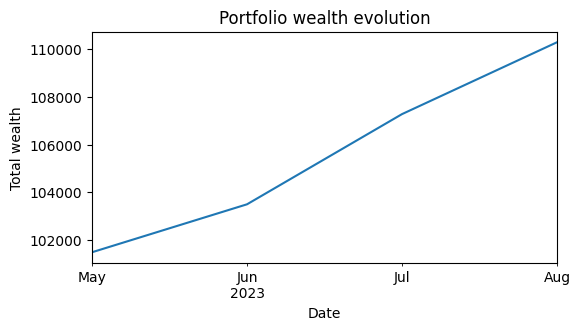

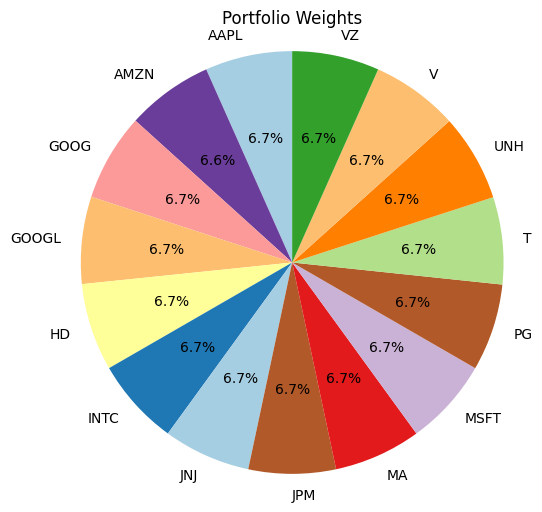

'\nweights.T.plot.area(title = \'Portfolio weights\',\n                  ylabel = \'Weights\', xlabel = \'Rebalance Period\',\n                  figsize = (6, 3),\n                  legend = True, stacked = True)\nplt.legend(loc=\'center left\', bbox_to_anchor=(1.0, 0.5))\nplt.savefig("/content/drive/My Drive/MIE479 Capstone Project/Portfolio Construction/images/weights.svg");\n'

In [611]:
#--------------------------------------------------------------------------
# 3.2 Portfolio wealth evolution plot
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.plot(title = 'Portfolio wealth evolution',
                ylabel = 'Total wealth',
                figsize = (6, 3),
                legend = False)
plt.savefig("/content/drive/My Drive/MIE479 Capstone Project/Portfolio Construction/images/wealth.svg")

#--------------------------------------------------------------------------
# 3.3 Portfolio weights plot
#--------------------------------------------------------------------------
# Portfolio weights


fig2 = plt.figure(2);

x[x < 0] = 0
weights = pd.DataFrame(x, index = tickers)
weights.columns = [col + 1 for col in weights.columns]

# Plotting a pie chart
fig, ax = plt.subplots(figsize=(6, 6))
colors = plt.cm.Paired(np.linspace(0, 1, len(tickers)))
np.random.shuffle(colors)

ax.pie(x[:,0], labels=tickers, autopct='%1.1f%%', startangle=90, colors=colors)
ax.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Add a title
plt.title('Portfolio Weights')
plt.savefig("/content/drive/My Drive/MIE479 Capstone Project/Portfolio Construction/images/weights.svg");

# Show the plot
plt.show()
'''
weights.T.plot.area(title = 'Portfolio weights',
                  ylabel = 'Weights', xlabel = 'Rebalance Period',
                  figsize = (6, 3),
                  legend = True, stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("/content/drive/My Drive/MIE479 Capstone Project/Portfolio Construction/images/weights.svg");
'''

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Program End